# Optimizing model parameters

In the introduction tutorial, we took the gradient of the waveform with respect to the source parameters. In this tutorial, we will show an example of how to use the gradient with respect to the model parameters, i.e. the fitting paramteres of the surrogate model, to optimize the model parameters with respect to a loss function.

In [24]:
from jaxnrsur.NRHybSur3dq8 import NRHybSur3dq8Model
from jaxnrsur.NRSur7dq4 import NRSur7dq4Model
from jaxnrsur.PolyPredictor import PolyPredictor
import jax.numpy as jnp
import jax
import equinox as eqx
import optax
from jaxtyping import PyTree, Float
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)  # Use double precision

As a toy example, we will try to optimize the model parameters of the `NRSur7dq4` model to fit a target waveform generated by `NRHybSur3dq8` model. There is no inherent reason to do this, but it is a good example to show how to use the gradient with respect to the model parameters. First, let's initialize both models and make sure the are functioning correctly.

In [9]:
time = jnp.linspace(-5000, 100, 10000)
params_7d = jnp.array([0.9, 0.1, 0.4, 0.1, 0.5, 0.1, 0.3])
model_7d = NRSur7dq4Model()
hp_7d, hc_7d = model_7d(time, params_7d)

params_3d = params_7d[:3]  # Use only the first three parameters for the 3dq8 model
model_3d = NRHybSur3dq8Model()
hp_3d, hc_3d = model_3d(time, params_3d)
# Check if the models are working correctly

print ("NRSur7dq4 model output shape:", hp_7d.shape, hc_7d.shape)
print ("NRHybSur3dq8 model output shape:", hp_3d.shape, hc_3d.shape)


Try loading file from cache
Cache found and loading data
Try loading file from cache
Cache found and loading data
NRSur7dq4 model output shape: (10000,) (10000,)
NRHybSur3dq8 model output shape: (10000,) (10000,)


Unlike source parameters which are directly defined in the function, the model parameters are defined as attributes of the model class. All the NR surrogate models are based on `Module` from `Equinox`, which means we have to use `Equinox` filtering and partitioning to make sure we can take gradient with respect to the model parameters which are compatible with `jax`'s transformation functions such as `jax.grad` and `jax.jit`, but not the static parameters. 


In [10]:
# The following three lines partition the model into parts that are related to the 
# PolyPredictor and the rest of the model. This is necessary because we want to optimize
# the PolyPredictor parameters, but not other parameters such as the surrogate time grid
# or the maximum number of nodes.

def filter_func(x):
    return isinstance(x, PolyPredictor)

def partition_model(model: NRSur7dq4Model) -> tuple[NRSur7dq4Model, PyTree, PyTree]:
    filtered_module, filter_static = eqx.partition(model, filter_func, is_leaf=filter_func)
    dynamic, static = eqx.partition(filtered_module, eqx.is_array)
    return dynamic, static, filter_static

dynamic, static, filter_static = partition_model(model_7d)

# Define the loss function to optimize the model parameters
def loss(dynamic, static, filter_static, time, params):
    model = eqx.combine(eqx.combine(dynamic, static), filter_static, is_leaf=filter_func)
    hp, hc = model(time, params)
    return jnp.mean( (hp - hp_3d)**2 + (hc - hc_3d)**2 )

# Let's test the loss function.
loss_value = eqx.filter_jit(eqx.filter_value_and_grad(loss))(dynamic, static, filter_static, time, params_7d)


We will then define the objects that are related to the optimization. We are using the standard `adam` optimizer from `optax`. In the code below, `opt_state` referes to the state of the optimizer regarding the parameters of model. We define another function named `optimize_loss` that takes the model and the optimizer state as input, and returns the updated model. This is essentially taking a step in the optimization process. 

In [58]:
optim = optax.adam(learning_rate=1e-7)
opt_state = optim.init(eqx.filter(eqx.filter(model_7d, filter_func, is_leaf=filter_func), eqx.is_array))

@eqx.filter_jit
def optimize_loss(model: NRSur7dq4Model, opt_state:  PyTree) -> tuple[NRSur7dq4Model, PyTree, Float]:
    values, grads = eqx.filter_value_and_grad(loss)(model, static, filter_static, time, params_7d)
    updates, opt_state = optim.update(grads, opt_state, eqx.filter(eqx.filter(model, filter_func, is_leaf=filter_func), eqx.is_array))
    model = eqx.apply_updates(model, updates)
    return model, opt_state, values

Let's use the optimize_loss function to update our model. `optimized_model` is the updated model, which we combine with the static parameters and the filter to get the complete model. We can then use the updated model to generate a new waveform and check if it is indeed different from the original model waveform.

In [59]:
losses = []
current_model = dynamic
for _ in range(500):
    current_model, opt_state, loss_value = optimize_loss(current_model, opt_state)
    losses.append(loss_value)

losses = jnp.array(losses)
combined_model = eqx.combine(eqx.combine(current_model, static), filter_static, is_leaf=filter_func)
new_h = combined_model(time, params_7d)


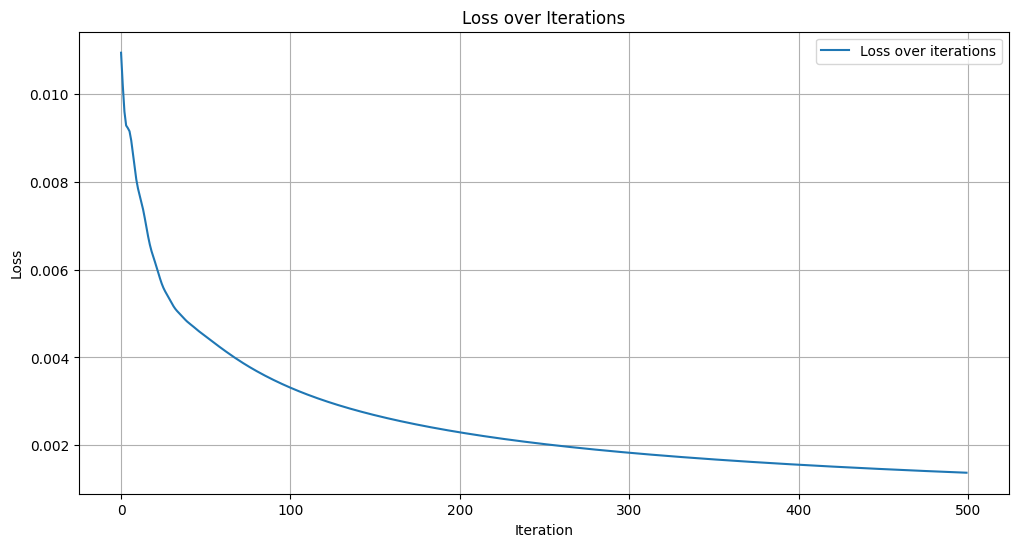

In [60]:
plt.figure(figsize=(12, 6))
plt.plot(losses, label='Loss over iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss over Iterations')
plt.legend()
plt.grid()
plt.show()

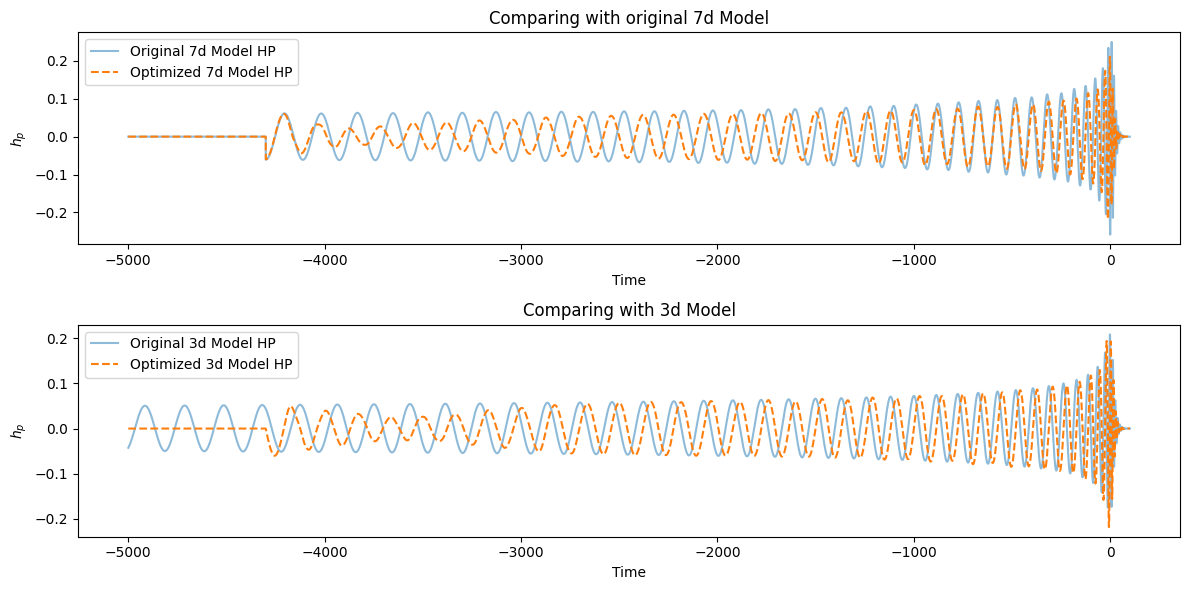

In [64]:
fig, ax = plt.subplots(2,1, figsize=(12, 6))
ax[0].plot(time, hp_7d, label='Original 7d Model HP', alpha=0.5)
ax[0].plot(time, new_h[0], label='Optimized 7d Model HP', linestyle='--')
ax[0].set_title('Comparing with original 7d Model')
ax[0].set_xlabel('Time')
ax[0].set_ylabel(r'$h_p$')
ax[0].legend()
ax[1].plot(time, hp_3d, label='Original 3d Model HP', alpha=0.5)
ax[1].plot(time, new_h[1], label='Optimized 3d Model HP', linestyle='--')
ax[1].set_title('Comparing with 3d Model')
ax[1].set_xlabel('Time')
ax[1].set_ylabel(r'$h_p$')
ax[1].legend()
plt.tight_layout()
plt.show()

This is just a crude example to show how one can change the model parameters instead of producing any physically meaningful results, but one can see that the model is indeed updated.